In [1]:
import numpy as np
import pandas as pd

def Peaks(x, y):
    z = 3*(1-x)**2 * np.exp(-(x**2) - (y+1)**2) - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2) - 1/3 * np.exp(-(x+1)**2 - y**2)
    return z

def GetGrid(grid):
    x = np.linspace(-2, 2, grid)
    y = np.linspace(-2, 2, grid)
    x, y = np.meshgrid(x, y)
    z = Peaks(x, y)
    return x, y, z

def create_dataframe(grid):
   x, y, z = GetGrid(grid)
   data = {'x1': x.flatten(), 'x2': y.flatten(), 'f(x1,x2)': z.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Gaussian")

/tmp/ipykernel_891850/3623673326.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


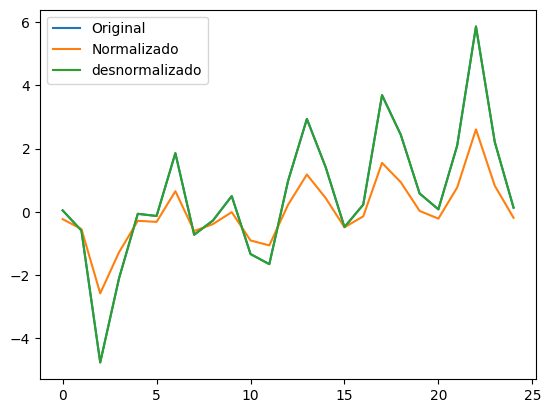

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...


remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.


remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 16.50 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-08-25 02:25:38.483105: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-25 02:25:38.539535: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-25 02:25:38.539578: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-25 02:25:38.540921: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-25 02:25:38.549179: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-25 02:25:38.550174: I tensorflow/core/platform/cpu_feature_guard.cc:1

2024-08-25 02:25:40.251430: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [8]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[12, 2]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[12, 2], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 3 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 5 ++++++++++++++++++


Stopped at epoch:  21
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 6 ++++++++++++++++++

Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 1 ++++++++++++++++++


Stopped at epoch:  10


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 5 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 6 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 10 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_1_2,0.922385,0.721136,0.741306,0.896214,0.336053,1.864762,0.925334,0.570732,0.762367,0.579701,5.967348,0.588830,132.180974,273.516147
model_1_1_1,0.904965,0.705084,0.716364,0.884174,0.411477,1.972105,1.014550,0.636938,0.942431,0.641465,7.082226,0.651567,131.776005,273.111178
model_1_1_0,0.892766,0.693472,0.702916,0.874160,0.464298,2.049755,1.062653,0.692009,1.022376,0.681394,7.863002,0.692126,131.534457,272.869629


DataFrame salvo em ../results/metrics_1_1


+++++++++++ [1_2] | 1 ++++++++++++++++++


Stopped at epoch:  14
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 6 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 10 ++++++++++++++++++


Stopped at epoch:  11
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_9,0.984346,0.790735,0.799724,0.981873,0.067777,1.399357,0.716375,0.055346,0.268401,0.260341,2.001846,0.264441,135.383057,276.718230
model_1_2_8,0.979541,0.782148,0.804341,0.979093,0.088582,1.456775,0.699860,0.063833,0.285019,0.297628,2.309374,0.302315,134.847648,276.182821
model_1_2_7,0.979180,0.781874,0.804213,0.978684,0.090147,1.458613,0.700320,0.065082,0.285713,0.300245,2.332501,0.304973,134.812631,276.147804
model_1_2_6,0.976718,0.778645,0.805863,0.976515,0.100807,1.480203,0.694417,0.071703,0.292947,0.317501,2.490075,0.322502,134.589093,275.924266
model_1_2_5,0.974117,0.776122,0.800214,0.974597,0.112066,1.497076,0.714623,0.077558,0.377954,0.334763,2.656506,0.340036,134.377326,275.712499
model_1_2_4,0.969065,0.769571,0.793009,0.969314,0.133939,1.540877,0.740394,0.093690,0.430117,0.365977,2.979818,0.371741,134.020737,275.355910
model_1_2_3,0.965059,0.764933,0.791524,0.964793,0.151285,1.571892,0.745708,0.107494,0.419823,0.388954,3.236213,0.395079,133.777179,275.112352
model_1_2_2,0.960086,0.759217,0.787964,0.959571,0.172817,1.610116,0.758441,0.123436,0.444982,0.415712,3.554484,0.422259,133.511047,274.846219
model_1_2_1,0.952637,0.750910,0.776561,0.949758,0.205069,1.665666,0.799228,0.153397,0.510693,0.452845,4.031214,0.459977,133.168820,274.503993
model_1_2_0,0.943212,0.741556,0.762527,0.939862,0.245879,1.728217,0.849428,0.183610,0.617552,0.495862,4.634455,0.503672,132.805828,274.141001


DataFrame salvo em ../results/metrics_1_2


+++++++++++ [1_3] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 5 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 10 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_9,0.995984,0.811196,0.819600,0.995005,0.017389,1.262535,0.645279,0.023966,0.234663,0.131869,1.257041,0.133946,138.103789,279.438962
model_1_3_8,0.995749,0.810733,0.819362,0.994762,0.018408,1.265628,0.646131,0.025128,0.241089,0.135675,1.272093,0.137812,137.989969,279.325141
model_1_3_7,0.995162,0.809369,0.818389,0.994091,0.020946,1.274751,0.649610,0.028349,0.253161,0.144727,1.309609,0.147006,137.731634,279.066806
model_1_3_6,0.994422,0.807837,0.818024,0.993230,0.024149,1.284993,0.650918,0.032479,0.269130,0.155401,1.356963,0.157848,137.446993,278.782166
model_1_3_5,0.993607,0.806373,0.817366,0.992258,0.027679,1.294782,0.653270,0.037140,0.286241,0.166371,1.409141,0.168991,137.174136,278.509308
model_1_3_4,0.992654,0.804765,0.816221,0.991059,0.031807,1.305536,0.657365,0.042894,0.306037,0.178344,1.470147,0.181153,136.896165,278.231338
model_1_3_3,0.991569,0.803323,0.811358,0.990269,0.036503,1.315179,0.674760,0.046687,0.285937,0.191059,1.539575,0.194068,136.620695,277.955867
model_1_3_2,0.990428,0.800973,0.810266,0.988889,0.041444,1.330896,0.678668,0.053305,0.292966,0.203579,1.612609,0.206785,136.366804,277.701977
model_1_3_1,0.988023,0.796689,0.804684,0.985922,0.051858,1.359540,0.698632,0.067541,0.235540,0.227723,1.766536,0.231310,135.918495,277.253667
model_1_3_0,0.986302,0.793585,0.801861,0.984094,0.059310,1.380298,0.708732,0.076307,0.253950,0.243537,1.876695,0.247373,135.649939,276.985111


DataFrame salvo em ../results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 6 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 10 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 34ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_9,0.998773,0.821749,0.811919,0.998917,0.005314,1.191968,0.672755,0.006926,0.181167,0.072897,1.078548,0.074045,140.474827,281.810000
model_1_4_8,0.998692,0.821612,0.811512,0.998831,0.005662,1.192883,0.674211,0.007476,0.185858,0.075246,1.083692,0.076431,140.347972,281.683145
model_1_4_7,0.998549,0.821496,0.811411,0.998785,0.006282,1.193654,0.674573,0.007773,0.196640,0.079260,1.092860,0.080509,140.140067,281.475240
model_1_4_6,0.998528,0.821480,0.811399,0.998791,0.006372,1.193761,0.674615,0.007735,0.198065,0.079827,1.094192,0.081084,140.111593,281.446765
model_1_4_5,0.998510,0.821468,0.811367,0.998798,0.006450,1.193844,0.674729,0.007689,0.199275,0.080314,1.095344,0.081578,140.087265,281.422438
model_1_4_4,0.997611,0.815068,0.818891,0.997803,0.010343,1.236644,0.647816,0.014050,0.187939,0.101699,1.152879,0.103300,139.142969,280.478141
model_1_4_3,0.997179,0.813923,0.819795,0.997438,0.012215,1.244300,0.644583,0.016384,0.197538,0.110523,1.180561,0.112264,138.810123,280.145296
model_1_4_2,0.996855,0.812965,0.819465,0.997194,0.013617,1.250703,0.645763,0.017947,0.207571,0.116691,1.201277,0.118529,138.592891,279.928063
model_1_4_0,0.996491,0.812245,0.819913,0.996968,0.015191,1.255517,0.644159,0.019394,0.219470,0.123254,1.224551,0.125195,138.374048,279.709220
model_1_4_1,0.996495,0.812110,0.819624,0.996923,0.015176,1.256424,0.645194,0.019682,0.218427,0.123193,1.224329,0.125133,138.376027,279.711199


DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

11/32 [=========>....................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_5] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 7 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 8 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_9,0.999471,0.823055,0.816434,0.999395,0.002291,1.183231,0.656606,0.002357,0.104411,0.047865,1.033865,0.048619,142.157499,283.492671
model_1_5_8,0.999421,0.822769,0.816465,0.999463,0.002507,1.185145,0.656495,0.002092,0.111381,0.050067,1.037053,0.050856,141.977554,283.312727
model_1_5_7,0.999413,0.822689,0.816381,0.999467,0.002544,1.185681,0.656795,0.002076,0.112222,0.050435,1.037600,0.051229,141.948273,283.283445
model_1_5_6,0.999336,0.822094,0.815357,0.999412,0.002875,1.189661,0.660456,0.002291,0.125057,0.053619,1.042496,0.054463,141.703424,283.038597
model_1_5_0,0.998883,0.821919,0.812398,0.998981,0.004834,1.190826,0.671040,0.003968,0.170455,0.069529,1.071457,0.070624,140.664067,281.999239
model_1_5_1,0.998908,0.821897,0.812407,0.999023,0.004730,1.190977,0.671009,0.003806,0.167973,0.068774,1.069914,0.069857,140.707734,282.042906
model_1_5_5,0.999211,0.821798,0.814933,0.999311,0.003417,1.191636,0.661974,0.002682,0.134617,0.058454,1.050507,0.059375,141.358031,282.693203
model_1_5_4,0.999196,0.821726,0.814891,0.999299,0.003480,1.192116,0.662123,0.002732,0.135332,0.058990,1.051437,0.059919,141.321528,282.656700
model_1_5_3,0.999179,0.821540,0.814635,0.999276,0.003556,1.193361,0.663039,0.002819,0.136417,0.059632,1.052563,0.060571,141.278235,282.613408
model_1_5_2,0.999061,0.821118,0.814173,0.999183,0.004064,1.196182,0.664694,0.003182,0.144066,0.063750,1.060073,0.064754,141.011148,282.346321


DataFrame salvo em ../results/metrics_1_5


+++++++++++ [1_6] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 8 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 10 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_7,0.999658,0.823798,0.816419,0.999660,0.001481,1.178264,0.656658,0.001035,0.101342,0.038483,1.021890,0.039089,143.030164,284.365336
model_1_6_9,0.999669,0.823787,0.816193,0.999430,0.001433,1.178335,0.657467,0.001733,0.100136,0.037850,1.021176,0.038446,143.096519,284.431692
model_1_6_8,0.999661,0.823718,0.816182,0.999495,0.001467,1.178799,0.657508,0.001535,0.100666,0.038297,1.021679,0.038900,143.049575,284.384748
model_1_6_6,0.999648,0.823624,0.816162,0.999687,0.001526,1.179424,0.657579,0.000953,0.100384,0.039061,1.022553,0.039677,142.970484,284.305657
model_1_6_5,0.999607,0.823445,0.816464,0.999627,0.001700,1.180621,0.656498,0.001133,0.100418,0.041232,1.025130,0.041881,142.754151,284.089324
model_1_6_4,0.999544,0.823151,0.816311,0.999534,0.001973,1.182591,0.657045,0.001417,0.105425,0.044414,1.029158,0.045114,142.456796,283.791969
model_1_6_0,0.999480,0.823040,0.816437,0.999723,0.002251,1.183331,0.656595,0.000841,0.104967,0.047448,1.033278,0.048195,142.192490,283.527663
model_1_6_3,0.999539,0.822964,0.816221,0.999577,0.001996,1.183838,0.657368,0.001286,0.104014,0.044681,1.029509,0.045384,142.432858,283.768030
model_1_6_2,0.999502,0.822928,0.816333,0.999609,0.002155,1.184084,0.656966,0.001190,0.107416,0.046422,1.031854,0.047153,142.279956,283.615128
model_1_6_1,0.999491,0.822742,0.816185,0.999568,0.002205,1.185325,0.657497,0.001314,0.107915,0.046961,1.032597,0.047700,142.233793,283.568966


DataFrame salvo em ../results/metrics_1_6


+++++++++++ [1_7] | 1 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 2 ++++++++++++++++++


Stopped at epoch:  16
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 3 ++++++++++++++++++


Stopped at epoch:  17
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 4 ++++++++++++++++++


Stopped at epoch:  15
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 6 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 7 ++++++++++++++++++


Stopped at epoch:  13
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 9 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_9,0.999813,0.826912,0.818244,0.999348,0.000809,1.157443,0.650130,0.002555,0.056741,0.028448,1.011962,0.028896,144.238737,285.573910
model_1_7_8,0.999820,0.826847,0.818037,0.999389,0.000779,1.157872,0.650871,0.002397,0.055915,0.027913,1.011517,0.028353,144.314585,285.649757
model_1_7_7,0.999853,0.826499,0.817891,0.999618,0.000637,1.160200,0.651394,0.001500,0.048136,0.025244,1.009420,0.025642,144.716603,286.051776
model_1_7_6,0.999860,0.826198,0.817569,0.999708,0.000605,1.162213,0.652546,0.001144,0.048129,0.024607,1.008950,0.024994,144.818971,286.154144
model_1_7_5,0.999801,0.825518,0.817067,0.999488,0.000863,1.166761,0.654339,0.002007,0.058260,0.029381,1.012760,0.029843,144.109676,285.444849
model_1_7_4,0.999827,0.825395,0.817095,0.999682,0.000747,1.167588,0.654242,0.001248,0.051796,0.027336,1.011046,0.027767,144.398135,285.733307
model_1_7_3,0.999816,0.825094,0.817074,0.999711,0.000796,1.169595,0.654315,0.001133,0.054536,0.028222,1.011773,0.028666,144.270629,285.605801
model_1_7_2,0.999780,0.824795,0.817113,0.999693,0.000950,1.171594,0.654177,0.001204,0.057858,0.030829,1.014049,0.031315,143.917186,285.252359
model_1_7_1,0.999733,0.824007,0.816347,0.999747,0.001155,1.176868,0.656915,0.000993,0.064731,0.033991,1.017078,0.034527,143.526617,284.861790
model_1_7_0,0.999668,0.823166,0.815734,0.999694,0.001436,1.182489,0.659109,0.001198,0.088550,0.037900,1.021232,0.038497,143.091216,284.426388


DataFrame salvo em ../results/metrics_1_7


+++++++++++ [1_8] | 1 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 2 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 3 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 6 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_7,0.999817,0.827069,0.817513,0.999766,0.000794,1.156390,0.652745,0.001588,0.058482,0.028179,1.011737,0.028623,144.276703,285.611876
model_1_8_2,0.999820,0.827048,0.817810,0.999903,0.000781,1.156534,0.651683,0.000660,0.057908,0.027949,1.011546,0.028389,144.309537,285.644709
model_1_8_3,0.999814,0.827038,0.817381,0.999835,0.000807,1.156601,0.653218,0.001118,0.059578,0.028416,1.011936,0.028864,144.243199,285.578371
model_1_8_6,0.999818,0.827016,0.817527,0.999775,0.000787,1.156746,0.652695,0.001529,0.058076,0.028054,1.011633,0.028496,144.294521,285.629694
model_1_8_5,0.999815,0.827010,0.817297,0.999804,0.000801,1.156782,0.653518,0.001330,0.058456,0.028303,1.011841,0.028749,144.259171,285.594343
model_1_8_0,0.999799,0.827009,0.818508,0.999917,0.000870,1.156789,0.649185,0.000561,0.055508,0.029494,1.012858,0.029958,144.094310,285.429482
model_1_8_4,0.999815,0.826998,0.817404,0.999832,0.000801,1.156863,0.653135,0.001143,0.059699,0.028311,1.011847,0.028757,144.258064,285.593237
model_1_8_8,0.999823,0.826979,0.817432,0.999745,0.000765,1.156991,0.653034,0.001729,0.058166,0.027664,1.011312,0.028099,144.350564,285.685736
model_1_8_9,0.999830,0.826958,0.817346,0.999732,0.000737,1.157133,0.653343,0.001820,0.054594,0.027156,1.010901,0.027584,144.424590,285.759762
model_1_8_1,0.999807,0.826860,0.817729,0.999910,0.000835,1.157787,0.651974,0.000614,0.057706,0.028889,1.012336,0.029344,144.177134,285.512307


DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 5 ++++++++++++++++++


Stopped at epoch:  27
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_8,0.999849,0.828224,0.818091,0.999724,0.000652,1.148664,0.650677,0.002011,0.057853,0.025538,1.009640,0.025940,144.670372,286.005545
model_1_9_9,0.999848,0.828165,0.818036,0.999712,0.000657,1.149063,0.650874,0.002097,0.057064,0.025641,1.009718,0.026045,144.654260,285.989432
model_1_9_6,0.999880,0.827450,0.818373,0.999834,0.000521,1.153840,0.649670,0.001212,0.044763,0.022828,1.007703,0.023188,145.119025,286.454198
model_1_9_7,0.999879,0.827388,0.818364,0.999829,0.000522,1.154257,0.649700,0.001248,0.044936,0.022850,1.007718,0.023210,145.115240,286.450412
model_1_9_5,0.999869,0.827326,0.818244,0.999802,0.000568,1.154670,0.650129,0.001441,0.047806,0.023842,1.008402,0.024218,144.945219,286.280392
model_1_9_3,0.999865,0.827268,0.818466,0.999917,0.000583,1.155061,0.649338,0.000604,0.046409,0.024151,1.008622,0.024532,144.893691,286.228864
model_1_9_4,0.999886,0.827195,0.818958,0.999871,0.000492,1.155549,0.647578,0.000940,0.041825,0.022186,1.007276,0.022536,145.233137,286.568310
model_1_9_2,0.999857,0.827138,0.818449,0.999940,0.000618,1.155932,0.649398,0.000439,0.046891,0.024850,1.009128,0.025241,144.779655,286.114827
model_1_9_1,0.999855,0.827094,0.818292,0.999944,0.000628,1.156224,0.649959,0.000410,0.048763,0.025052,1.009277,0.025447,144.747191,286.082363
model_1_9_0,0.999841,0.826928,0.817240,0.999958,0.000690,1.157334,0.653721,0.000303,0.050365,0.026262,1.010194,0.026675,144.558578,285.893750


DataFrame salvo em ../results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 5 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 7 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 10 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_0,0.99983,0.828402,0.818097,0.999762,0.000735,1.14748,0.650656,0.001086,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_10_1,0.99983,0.828402,0.818097,0.999762,0.000735,1.14748,0.650656,0.001086,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_10_2,0.99983,0.828402,0.818097,0.999762,0.000735,1.14748,0.650656,0.001086,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_10_3,0.99983,0.828402,0.818097,0.999762,0.000735,1.14748,0.650656,0.001086,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_10_4,0.99983,0.828402,0.818097,0.999762,0.000735,1.14748,0.650656,0.001086,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_10_5,0.99983,0.828402,0.818097,0.999762,0.000735,1.14748,0.650656,0.001086,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_10_6,0.99983,0.828402,0.818097,0.999762,0.000735,1.14748,0.650656,0.001086,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_10_7,0.99983,0.828402,0.818097,0.999762,0.000735,1.14748,0.650656,0.001086,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_10_8,0.99983,0.828402,0.818097,0.999762,0.000735,1.14748,0.650656,0.001086,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_10_9,0.99983,0.828402,0.818097,0.999762,0.000735,1.14748,0.650656,0.001086,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_10


+++++++++++ [1_11] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 8 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 10 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_0,0.99983,0.828402,0.818097,0.999983,0.000735,1.14748,0.650656,0.000093,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_11_1,0.99983,0.828402,0.818097,0.999983,0.000735,1.14748,0.650656,0.000093,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_11_2,0.99983,0.828402,0.818097,0.999983,0.000735,1.14748,0.650656,0.000093,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_11_3,0.99983,0.828402,0.818097,0.999983,0.000735,1.14748,0.650656,0.000093,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_11_4,0.99983,0.828402,0.818097,0.999983,0.000735,1.14748,0.650656,0.000093,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_11_5,0.99983,0.828402,0.818097,0.999983,0.000735,1.14748,0.650656,0.000093,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_11_6,0.99983,0.828402,0.818097,0.999983,0.000735,1.14748,0.650656,0.000093,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_11_7,0.99983,0.828402,0.818097,0.999983,0.000735,1.14748,0.650656,0.000093,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_11_8,0.99983,0.828402,0.818097,0.999983,0.000735,1.14748,0.650656,0.000093,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_11_9,0.99983,0.828402,0.818097,0.999983,0.000735,1.14748,0.650656,0.000093,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 4 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 9 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_0,0.99983,0.828402,0.818097,0.999967,0.000735,1.14748,0.650656,0.000233,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_12_1,0.99983,0.828402,0.818097,0.999967,0.000735,1.14748,0.650656,0.000233,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_12_2,0.99983,0.828402,0.818097,0.999967,0.000735,1.14748,0.650656,0.000233,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_12_3,0.99983,0.828402,0.818097,0.999967,0.000735,1.14748,0.650656,0.000233,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_12_4,0.99983,0.828402,0.818097,0.999967,0.000735,1.14748,0.650656,0.000233,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_12_5,0.99983,0.828402,0.818097,0.999967,0.000735,1.14748,0.650656,0.000233,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_12_6,0.99983,0.828402,0.818097,0.999967,0.000735,1.14748,0.650656,0.000233,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_12_7,0.99983,0.828402,0.818097,0.999967,0.000735,1.14748,0.650656,0.000233,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_12_8,0.99983,0.828402,0.818097,0.999967,0.000735,1.14748,0.650656,0.000233,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_12_9,0.99983,0.828402,0.818097,0.999967,0.000735,1.14748,0.650656,0.000233,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_12


+++++++++++ [1_13] | 1 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 7 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 8 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_0,0.99983,0.828402,0.818097,0.999807,0.000735,1.14748,0.650656,0.000809,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_13_1,0.99983,0.828402,0.818097,0.999807,0.000735,1.14748,0.650656,0.000809,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_13_2,0.99983,0.828402,0.818097,0.999807,0.000735,1.14748,0.650656,0.000809,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_13_3,0.99983,0.828402,0.818097,0.999807,0.000735,1.14748,0.650656,0.000809,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_13_4,0.99983,0.828402,0.818097,0.999807,0.000735,1.14748,0.650656,0.000809,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_13_5,0.99983,0.828402,0.818097,0.999807,0.000735,1.14748,0.650656,0.000809,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_13_6,0.99983,0.828402,0.818097,0.999807,0.000735,1.14748,0.650656,0.000809,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_13_7,0.99983,0.828402,0.818097,0.999807,0.000735,1.14748,0.650656,0.000809,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_13_8,0.99983,0.828402,0.818097,0.999807,0.000735,1.14748,0.650656,0.000809,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_13_9,0.99983,0.828402,0.818097,0.999807,0.000735,1.14748,0.650656,0.000809,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_14] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_0,0.99983,0.828402,0.818097,0.999788,0.000735,1.14748,0.650656,0.000476,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_14_1,0.99983,0.828402,0.818097,0.999788,0.000735,1.14748,0.650656,0.000476,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_14_2,0.99983,0.828402,0.818097,0.999788,0.000735,1.14748,0.650656,0.000476,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_14_3,0.99983,0.828402,0.818097,0.999788,0.000735,1.14748,0.650656,0.000476,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_14_4,0.99983,0.828402,0.818097,0.999788,0.000735,1.14748,0.650656,0.000476,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_14_5,0.99983,0.828402,0.818097,0.999788,0.000735,1.14748,0.650656,0.000476,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_14_6,0.99983,0.828402,0.818097,0.999788,0.000735,1.14748,0.650656,0.000476,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_14_7,0.99983,0.828402,0.818097,0.999788,0.000735,1.14748,0.650656,0.000476,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_14_8,0.99983,0.828402,0.818097,0.999788,0.000735,1.14748,0.650656,0.000476,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_14_9,0.99983,0.828402,0.818097,0.999788,0.000735,1.14748,0.650656,0.000476,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_14


+++++++++++ [1_15] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 3 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 4 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_15] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 8 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_15_0,0.99983,0.828402,0.818097,0.999787,0.000735,1.14748,0.650656,0.000463,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_15_1,0.99983,0.828402,0.818097,0.999787,0.000735,1.14748,0.650656,0.000463,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_15_2,0.99983,0.828402,0.818097,0.999787,0.000735,1.14748,0.650656,0.000463,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_15_3,0.99983,0.828402,0.818097,0.999787,0.000735,1.14748,0.650656,0.000463,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_15_4,0.99983,0.828402,0.818097,0.999787,0.000735,1.14748,0.650656,0.000463,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_15_5,0.99983,0.828402,0.818097,0.999787,0.000735,1.14748,0.650656,0.000463,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_15_6,0.99983,0.828402,0.818097,0.999787,0.000735,1.14748,0.650656,0.000463,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_15_7,0.99983,0.828402,0.818097,0.999787,0.000735,1.14748,0.650656,0.000463,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_15_8,0.99983,0.828402,0.818097,0.999787,0.000735,1.14748,0.650656,0.000463,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_15_9,0.99983,0.828402,0.818097,0.999787,0.000735,1.14748,0.650656,0.000463,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_15


+++++++++++ [1_16] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 3 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 4 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 5 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 7 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 10 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_16_0,0.99983,0.828402,0.818097,0.999876,0.000735,1.14748,0.650656,0.000399,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_16_1,0.99983,0.828402,0.818097,0.999876,0.000735,1.14748,0.650656,0.000399,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_16_2,0.99983,0.828402,0.818097,0.999876,0.000735,1.14748,0.650656,0.000399,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_16_3,0.99983,0.828402,0.818097,0.999876,0.000735,1.14748,0.650656,0.000399,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_16_4,0.99983,0.828402,0.818097,0.999876,0.000735,1.14748,0.650656,0.000399,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_16_5,0.99983,0.828402,0.818097,0.999876,0.000735,1.14748,0.650656,0.000399,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_16_6,0.99983,0.828402,0.818097,0.999876,0.000735,1.14748,0.650656,0.000399,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_16_7,0.99983,0.828402,0.818097,0.999876,0.000735,1.14748,0.650656,0.000399,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_16_8,0.99983,0.828402,0.818097,0.999876,0.000735,1.14748,0.650656,0.000399,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_16_9,0.99983,0.828402,0.818097,0.999876,0.000735,1.14748,0.650656,0.000399,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_16


+++++++++++ [1_17] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_17] | 2 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_17_0,0.99983,0.828402,0.818097,0.999781,0.000735,1.14748,0.650656,0.001697,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_17_1,0.99983,0.828402,0.818097,0.999781,0.000735,1.14748,0.650656,0.001697,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_17_2,0.99983,0.828402,0.818097,0.999781,0.000735,1.14748,0.650656,0.001697,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_17_3,0.99983,0.828402,0.818097,0.999781,0.000735,1.14748,0.650656,0.001697,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_17_4,0.99983,0.828402,0.818097,0.999781,0.000735,1.14748,0.650656,0.001697,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_17_5,0.99983,0.828402,0.818097,0.999781,0.000735,1.14748,0.650656,0.001697,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_17_6,0.99983,0.828402,0.818097,0.999781,0.000735,1.14748,0.650656,0.001697,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_17_7,0.99983,0.828402,0.818097,0.999781,0.000735,1.14748,0.650656,0.001697,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_17_8,0.99983,0.828402,0.818097,0.999781,0.000735,1.14748,0.650656,0.001697,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_17_9,0.99983,0.828402,0.818097,0.999781,0.000735,1.14748,0.650656,0.001697,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_17


+++++++++++ [1_18] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 2 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 5 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 10 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_18_0,0.99983,0.828402,0.818097,0.999627,0.000735,1.14748,0.650656,0.001041,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_18_1,0.99983,0.828402,0.818097,0.999627,0.000735,1.14748,0.650656,0.001041,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_18_2,0.99983,0.828402,0.818097,0.999627,0.000735,1.14748,0.650656,0.001041,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_18_3,0.99983,0.828402,0.818097,0.999627,0.000735,1.14748,0.650656,0.001041,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_18_4,0.99983,0.828402,0.818097,0.999627,0.000735,1.14748,0.650656,0.001041,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_18_5,0.99983,0.828402,0.818097,0.999627,0.000735,1.14748,0.650656,0.001041,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_18_6,0.99983,0.828402,0.818097,0.999627,0.000735,1.14748,0.650656,0.001041,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_18_7,0.99983,0.828402,0.818097,0.999627,0.000735,1.14748,0.650656,0.001041,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_18_8,0.99983,0.828402,0.818097,0.999627,0.000735,1.14748,0.650656,0.001041,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_18_9,0.99983,0.828402,0.818097,0.999627,0.000735,1.14748,0.650656,0.001041,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_18
+++++++++++ [1_19] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_19_0,0.99983,0.828402,0.818097,0.999748,0.000735,1.14748,0.650656,0.001567,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_19_1,0.99983,0.828402,0.818097,0.999748,0.000735,1.14748,0.650656,0.001567,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_19_2,0.99983,0.828402,0.818097,0.999748,0.000735,1.14748,0.650656,0.001567,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_19_3,0.99983,0.828402,0.818097,0.999748,0.000735,1.14748,0.650656,0.001567,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_19_4,0.99983,0.828402,0.818097,0.999748,0.000735,1.14748,0.650656,0.001567,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_19_5,0.99983,0.828402,0.818097,0.999748,0.000735,1.14748,0.650656,0.001567,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_19_6,0.99983,0.828402,0.818097,0.999748,0.000735,1.14748,0.650656,0.001567,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_19_7,0.99983,0.828402,0.818097,0.999748,0.000735,1.14748,0.650656,0.001567,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_19_8,0.99983,0.828402,0.818097,0.999748,0.000735,1.14748,0.650656,0.001567,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_19_9,0.99983,0.828402,0.818097,0.999748,0.000735,1.14748,0.650656,0.001567,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_19
+++++++++++ [1_20] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_20] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 5 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_20] | 6 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 7 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 9 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_20_0,0.99983,0.828402,0.818097,0.99978,0.000735,1.14748,0.650656,0.001315,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_20_1,0.99983,0.828402,0.818097,0.99978,0.000735,1.14748,0.650656,0.001315,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_20_2,0.99983,0.828402,0.818097,0.99978,0.000735,1.14748,0.650656,0.001315,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_20_3,0.99983,0.828402,0.818097,0.99978,0.000735,1.14748,0.650656,0.001315,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_20_4,0.99983,0.828402,0.818097,0.99978,0.000735,1.14748,0.650656,0.001315,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_20_5,0.99983,0.828402,0.818097,0.99978,0.000735,1.14748,0.650656,0.001315,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_20_6,0.99983,0.828402,0.818097,0.99978,0.000735,1.14748,0.650656,0.001315,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_20_7,0.99983,0.828402,0.818097,0.99978,0.000735,1.14748,0.650656,0.001315,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_20_8,0.99983,0.828402,0.818097,0.99978,0.000735,1.14748,0.650656,0.001315,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_20_9,0.99983,0.828402,0.818097,0.99978,0.000735,1.14748,0.650656,0.001315,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_20


+++++++++++ [1_21] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 2 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 5 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 8 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_21_0,0.99983,0.828402,0.818097,0.999938,0.000735,1.14748,0.650656,0.000145,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_21_1,0.99983,0.828402,0.818097,0.999938,0.000735,1.14748,0.650656,0.000145,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_21_2,0.99983,0.828402,0.818097,0.999938,0.000735,1.14748,0.650656,0.000145,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_21_3,0.99983,0.828402,0.818097,0.999938,0.000735,1.14748,0.650656,0.000145,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_21_4,0.99983,0.828402,0.818097,0.999938,0.000735,1.14748,0.650656,0.000145,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_21_5,0.99983,0.828402,0.818097,0.999938,0.000735,1.14748,0.650656,0.000145,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_21_6,0.99983,0.828402,0.818097,0.999938,0.000735,1.14748,0.650656,0.000145,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_21_7,0.99983,0.828402,0.818097,0.999938,0.000735,1.14748,0.650656,0.000145,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_21_8,0.99983,0.828402,0.818097,0.999938,0.000735,1.14748,0.650656,0.000145,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_21_9,0.99983,0.828402,0.818097,0.999938,0.000735,1.14748,0.650656,0.000145,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_21
+++++++++++ [1_22] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 6 ++++++++++++++++++


Stopped at epoch: 

 0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 9 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_22_0,0.99983,0.828402,0.818097,0.999562,0.000735,1.14748,0.650656,0.001391,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_22_1,0.99983,0.828402,0.818097,0.999562,0.000735,1.14748,0.650656,0.001391,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_22_2,0.99983,0.828402,0.818097,0.999562,0.000735,1.14748,0.650656,0.001391,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_22_3,0.99983,0.828402,0.818097,0.999562,0.000735,1.14748,0.650656,0.001391,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_22_4,0.99983,0.828402,0.818097,0.999562,0.000735,1.14748,0.650656,0.001391,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_22_5,0.99983,0.828402,0.818097,0.999562,0.000735,1.14748,0.650656,0.001391,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_22_6,0.99983,0.828402,0.818097,0.999562,0.000735,1.14748,0.650656,0.001391,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_22_7,0.99983,0.828402,0.818097,0.999562,0.000735,1.14748,0.650656,0.001391,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_22_8,0.99983,0.828402,0.818097,0.999562,0.000735,1.14748,0.650656,0.001391,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_22_9,0.99983,0.828402,0.818097,0.999562,0.000735,1.14748,0.650656,0.001391,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_22


+++++++++++ [1_23] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 2 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 1s

15/32 [=============>................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_23] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 55ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 7 ++++++++++++++++++
Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 10 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_23_0,0.99983,0.828402,0.818097,0.999738,0.000735,1.14748,0.650656,0.001592,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_23_1,0.99983,0.828402,0.818097,0.999738,0.000735,1.14748,0.650656,0.001592,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_23_2,0.99983,0.828402,0.818097,0.999738,0.000735,1.14748,0.650656,0.001592,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_23_3,0.99983,0.828402,0.818097,0.999738,0.000735,1.14748,0.650656,0.001592,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_23_4,0.99983,0.828402,0.818097,0.999738,0.000735,1.14748,0.650656,0.001592,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_23_5,0.99983,0.828402,0.818097,0.999738,0.000735,1.14748,0.650656,0.001592,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_23_6,0.99983,0.828402,0.818097,0.999738,0.000735,1.14748,0.650656,0.001592,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_23_7,0.99983,0.828402,0.818097,0.999738,0.000735,1.14748,0.650656,0.001592,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_23_8,0.99983,0.828402,0.818097,0.999738,0.000735,1.14748,0.650656,0.001592,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_23_9,0.99983,0.828402,0.818097,0.999738,0.000735,1.14748,0.650656,0.001592,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_23


+++++++++++ [1_24] | 1 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 2 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 4 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 5 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 8 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_24_0,0.99983,0.828402,0.818097,0.999699,0.000735,1.14748,0.650656,0.00033,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_24_1,0.99983,0.828402,0.818097,0.999699,0.000735,1.14748,0.650656,0.00033,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_24_2,0.99983,0.828402,0.818097,0.999699,0.000735,1.14748,0.650656,0.00033,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_24_3,0.99983,0.828402,0.818097,0.999699,0.000735,1.14748,0.650656,0.00033,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_24_4,0.99983,0.828402,0.818097,0.999699,0.000735,1.14748,0.650656,0.00033,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_24_5,0.99983,0.828402,0.818097,0.999699,0.000735,1.14748,0.650656,0.00033,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_24_6,0.99983,0.828402,0.818097,0.999699,0.000735,1.14748,0.650656,0.00033,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_24_7,0.99983,0.828402,0.818097,0.999699,0.000735,1.14748,0.650656,0.00033,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_24_8,0.99983,0.828402,0.818097,0.999699,0.000735,1.14748,0.650656,0.00033,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_24_9,0.99983,0.828402,0.818097,0.999699,0.000735,1.14748,0.650656,0.00033,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_24


+++++++++++ [1_25] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 3 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 4 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 8 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 9 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 10 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_25_0,0.99983,0.828402,0.818097,0.999808,0.000735,1.14748,0.650656,0.001418,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_25_1,0.99983,0.828402,0.818097,0.999808,0.000735,1.14748,0.650656,0.001418,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_25_2,0.99983,0.828402,0.818097,0.999808,0.000735,1.14748,0.650656,0.001418,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_25_3,0.99983,0.828402,0.818097,0.999808,0.000735,1.14748,0.650656,0.001418,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_25_4,0.99983,0.828402,0.818097,0.999808,0.000735,1.14748,0.650656,0.001418,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_25_5,0.99983,0.828402,0.818097,0.999808,0.000735,1.14748,0.650656,0.001418,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_25_6,0.99983,0.828402,0.818097,0.999808,0.000735,1.14748,0.650656,0.001418,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_25_7,0.99983,0.828402,0.818097,0.999808,0.000735,1.14748,0.650656,0.001418,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_25_8,0.99983,0.828402,0.818097,0.999808,0.000735,1.14748,0.650656,0.001418,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_25_9,0.99983,0.828402,0.818097,0.999808,0.000735,1.14748,0.650656,0.001418,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_25


+++++++++++ [1_26] | 1 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 7 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 8 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 9 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_26_0,0.99983,0.828402,0.818097,0.999869,0.000735,1.14748,0.650656,0.000548,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_26_1,0.99983,0.828402,0.818097,0.999869,0.000735,1.14748,0.650656,0.000548,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_26_2,0.99983,0.828402,0.818097,0.999869,0.000735,1.14748,0.650656,0.000548,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_26_3,0.99983,0.828402,0.818097,0.999869,0.000735,1.14748,0.650656,0.000548,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_26_4,0.99983,0.828402,0.818097,0.999869,0.000735,1.14748,0.650656,0.000548,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_26_5,0.99983,0.828402,0.818097,0.999869,0.000735,1.14748,0.650656,0.000548,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_26_6,0.99983,0.828402,0.818097,0.999869,0.000735,1.14748,0.650656,0.000548,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_26_7,0.99983,0.828402,0.818097,0.999869,0.000735,1.14748,0.650656,0.000548,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_26_8,0.99983,0.828402,0.818097,0.999869,0.000735,1.14748,0.650656,0.000548,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_26_9,0.99983,0.828402,0.818097,0.999869,0.000735,1.14748,0.650656,0.000548,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_26
+++++++++++ [1_27] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 2 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 3 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 4 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 7 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 9 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 7ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 1s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 10 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_27_0,0.99983,0.828402,0.818097,0.999915,0.000735,1.14748,0.650656,0.000575,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_27_1,0.99983,0.828402,0.818097,0.999915,0.000735,1.14748,0.650656,0.000575,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_27_2,0.99983,0.828402,0.818097,0.999915,0.000735,1.14748,0.650656,0.000575,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_27_3,0.99983,0.828402,0.818097,0.999915,0.000735,1.14748,0.650656,0.000575,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_27_4,0.99983,0.828402,0.818097,0.999915,0.000735,1.14748,0.650656,0.000575,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_27_5,0.99983,0.828402,0.818097,0.999915,0.000735,1.14748,0.650656,0.000575,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_27_6,0.99983,0.828402,0.818097,0.999915,0.000735,1.14748,0.650656,0.000575,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_27_7,0.99983,0.828402,0.818097,0.999915,0.000735,1.14748,0.650656,0.000575,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_27_8,0.99983,0.828402,0.818097,0.999915,0.000735,1.14748,0.650656,0.000575,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_27_9,0.99983,0.828402,0.818097,0.999915,0.000735,1.14748,0.650656,0.000575,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_27


+++++++++++ [1_28] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 2 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 3 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 4 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_28_0,0.99983,0.828402,0.818097,0.99982,0.000735,1.14748,0.650656,0.000936,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_28_1,0.99983,0.828402,0.818097,0.99982,0.000735,1.14748,0.650656,0.000936,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_28_2,0.99983,0.828402,0.818097,0.99982,0.000735,1.14748,0.650656,0.000936,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_28_3,0.99983,0.828402,0.818097,0.99982,0.000735,1.14748,0.650656,0.000936,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_28_4,0.99983,0.828402,0.818097,0.99982,0.000735,1.14748,0.650656,0.000936,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_28_5,0.99983,0.828402,0.818097,0.99982,0.000735,1.14748,0.650656,0.000936,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_28_6,0.99983,0.828402,0.818097,0.99982,0.000735,1.14748,0.650656,0.000936,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_28_7,0.99983,0.828402,0.818097,0.99982,0.000735,1.14748,0.650656,0.000936,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_28_8,0.99983,0.828402,0.818097,0.99982,0.000735,1.14748,0.650656,0.000936,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_28_9,0.99983,0.828402,0.818097,0.99982,0.000735,1.14748,0.650656,0.000936,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_28
+++++++++++ [1_29] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 3 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 33ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 4 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_29_0,0.99983,0.828402,0.818097,0.999971,0.000735,1.14748,0.650656,0.000128,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_29_1,0.99983,0.828402,0.818097,0.999971,0.000735,1.14748,0.650656,0.000128,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_29_2,0.99983,0.828402,0.818097,0.999971,0.000735,1.14748,0.650656,0.000128,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_29_3,0.99983,0.828402,0.818097,0.999971,0.000735,1.14748,0.650656,0.000128,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_29_4,0.99983,0.828402,0.818097,0.999971,0.000735,1.14748,0.650656,0.000128,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_29_5,0.99983,0.828402,0.818097,0.999971,0.000735,1.14748,0.650656,0.000128,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_29_6,0.99983,0.828402,0.818097,0.999971,0.000735,1.14748,0.650656,0.000128,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_29_7,0.99983,0.828402,0.818097,0.999971,0.000735,1.14748,0.650656,0.000128,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_29_8,0.99983,0.828402,0.818097,0.999971,0.000735,1.14748,0.650656,0.000128,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_29_9,0.99983,0.828402,0.818097,0.999971,0.000735,1.14748,0.650656,0.000128,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_29


+++++++++++ [1_30] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 2 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 1s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 5 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 9 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 10 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 59ms/step


 1/32 [..............................] - ETA: 1s

11/32 [=========>....................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 6ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_30_0,0.99983,0.828402,0.818097,0.999737,0.000735,1.14748,0.650656,0.001011,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_30_1,0.99983,0.828402,0.818097,0.999737,0.000735,1.14748,0.650656,0.001011,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_30_2,0.99983,0.828402,0.818097,0.999737,0.000735,1.14748,0.650656,0.001011,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_30_3,0.99983,0.828402,0.818097,0.999737,0.000735,1.14748,0.650656,0.001011,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_30_4,0.99983,0.828402,0.818097,0.999737,0.000735,1.14748,0.650656,0.001011,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_30_5,0.99983,0.828402,0.818097,0.999737,0.000735,1.14748,0.650656,0.001011,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_30_6,0.99983,0.828402,0.818097,0.999737,0.000735,1.14748,0.650656,0.001011,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_30_7,0.99983,0.828402,0.818097,0.999737,0.000735,1.14748,0.650656,0.001011,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_30_8,0.99983,0.828402,0.818097,0.999737,0.000735,1.14748,0.650656,0.001011,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_30_9,0.99983,0.828402,0.818097,0.999737,0.000735,1.14748,0.650656,0.001011,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_30
+++++++++++ [1_31] | 1 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_31] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_31] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 9 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 10 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_31_0,0.99983,0.828402,0.818097,0.999914,0.000735,1.14748,0.650656,0.00049,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_31_1,0.99983,0.828402,0.818097,0.999914,0.000735,1.14748,0.650656,0.00049,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_31_2,0.99983,0.828402,0.818097,0.999914,0.000735,1.14748,0.650656,0.00049,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_31_3,0.99983,0.828402,0.818097,0.999914,0.000735,1.14748,0.650656,0.00049,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_31_4,0.99983,0.828402,0.818097,0.999914,0.000735,1.14748,0.650656,0.00049,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_31_5,0.99983,0.828402,0.818097,0.999914,0.000735,1.14748,0.650656,0.00049,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_31_6,0.99983,0.828402,0.818097,0.999914,0.000735,1.14748,0.650656,0.00049,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_31_7,0.99983,0.828402,0.818097,0.999914,0.000735,1.14748,0.650656,0.00049,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_31_8,0.99983,0.828402,0.818097,0.999914,0.000735,1.14748,0.650656,0.00049,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_31_9,0.99983,0.828402,0.818097,0.999914,0.000735,1.14748,0.650656,0.00049,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_31


+++++++++++ [1_32] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 3 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_32] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 6 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 7 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_32] | 8 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 9 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_32_0,0.99983,0.828402,0.818097,0.99969,0.000735,1.14748,0.650656,0.00181,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_32_1,0.99983,0.828402,0.818097,0.99969,0.000735,1.14748,0.650656,0.00181,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_32_2,0.99983,0.828402,0.818097,0.99969,0.000735,1.14748,0.650656,0.00181,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_32_3,0.99983,0.828402,0.818097,0.99969,0.000735,1.14748,0.650656,0.00181,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_32_4,0.99983,0.828402,0.818097,0.99969,0.000735,1.14748,0.650656,0.00181,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_32_5,0.99983,0.828402,0.818097,0.99969,0.000735,1.14748,0.650656,0.00181,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_32_6,0.99983,0.828402,0.818097,0.99969,0.000735,1.14748,0.650656,0.00181,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_32_7,0.99983,0.828402,0.818097,0.99969,0.000735,1.14748,0.650656,0.00181,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_32_8,0.99983,0.828402,0.818097,0.99969,0.000735,1.14748,0.650656,0.00181,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_32_9,0.99983,0.828402,0.818097,0.99969,0.000735,1.14748,0.650656,0.00181,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_32


+++++++++++ [1_33] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_33] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 4 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_33] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 10 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_33_0,0.99983,0.828402,0.818097,0.99993,0.000735,1.14748,0.650656,0.000204,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_33_1,0.99983,0.828402,0.818097,0.99993,0.000735,1.14748,0.650656,0.000204,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_33_2,0.99983,0.828402,0.818097,0.99993,0.000735,1.14748,0.650656,0.000204,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_33_3,0.99983,0.828402,0.818097,0.99993,0.000735,1.14748,0.650656,0.000204,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_33_4,0.99983,0.828402,0.818097,0.99993,0.000735,1.14748,0.650656,0.000204,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_33_5,0.99983,0.828402,0.818097,0.99993,0.000735,1.14748,0.650656,0.000204,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_33_6,0.99983,0.828402,0.818097,0.99993,0.000735,1.14748,0.650656,0.000204,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_33_7,0.99983,0.828402,0.818097,0.99993,0.000735,1.14748,0.650656,0.000204,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_33_8,0.99983,0.828402,0.818097,0.99993,0.000735,1.14748,0.650656,0.000204,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_33_9,0.99983,0.828402,0.818097,0.99993,0.000735,1.14748,0.650656,0.000204,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_33


+++++++++++ [1_34] | 1 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 2 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 4 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 7 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 10 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_34_0,0.99983,0.828402,0.818097,0.999961,0.000735,1.14748,0.650656,0.000265,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_34_1,0.99983,0.828402,0.818097,0.999961,0.000735,1.14748,0.650656,0.000265,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_34_2,0.99983,0.828402,0.818097,0.999961,0.000735,1.14748,0.650656,0.000265,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_34_3,0.99983,0.828402,0.818097,0.999961,0.000735,1.14748,0.650656,0.000265,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_34_4,0.99983,0.828402,0.818097,0.999961,0.000735,1.14748,0.650656,0.000265,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_34_5,0.99983,0.828402,0.818097,0.999961,0.000735,1.14748,0.650656,0.000265,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_34_6,0.99983,0.828402,0.818097,0.999961,0.000735,1.14748,0.650656,0.000265,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_34_7,0.99983,0.828402,0.818097,0.999961,0.000735,1.14748,0.650656,0.000265,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_34_8,0.99983,0.828402,0.818097,0.999961,0.000735,1.14748,0.650656,0.000265,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_34_9,0.99983,0.828402,0.818097,0.999961,0.000735,1.14748,0.650656,0.000265,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_34


+++++++++++ [1_35] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 3 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 6 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_35_0,0.99983,0.828402,0.818097,0.999363,0.000735,1.14748,0.650656,0.001464,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_35_1,0.99983,0.828402,0.818097,0.999363,0.000735,1.14748,0.650656,0.001464,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_35_2,0.99983,0.828402,0.818097,0.999363,0.000735,1.14748,0.650656,0.001464,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_35_3,0.99983,0.828402,0.818097,0.999363,0.000735,1.14748,0.650656,0.001464,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_35_4,0.99983,0.828402,0.818097,0.999363,0.000735,1.14748,0.650656,0.001464,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_35_5,0.99983,0.828402,0.818097,0.999363,0.000735,1.14748,0.650656,0.001464,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_35_6,0.99983,0.828402,0.818097,0.999363,0.000735,1.14748,0.650656,0.001464,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_35_7,0.99983,0.828402,0.818097,0.999363,0.000735,1.14748,0.650656,0.001464,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_35_8,0.99983,0.828402,0.818097,0.999363,0.000735,1.14748,0.650656,0.001464,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_35_9,0.99983,0.828402,0.818097,0.999363,0.000735,1.14748,0.650656,0.001464,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_35


+++++++++++ [1_36] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 2 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_36] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_36_0,0.99983,0.828402,0.818097,0.999628,0.000735,1.14748,0.650656,0.001237,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_36_1,0.99983,0.828402,0.818097,0.999628,0.000735,1.14748,0.650656,0.001237,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_36_2,0.99983,0.828402,0.818097,0.999628,0.000735,1.14748,0.650656,0.001237,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_36_3,0.99983,0.828402,0.818097,0.999628,0.000735,1.14748,0.650656,0.001237,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_36_4,0.99983,0.828402,0.818097,0.999628,0.000735,1.14748,0.650656,0.001237,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_36_5,0.99983,0.828402,0.818097,0.999628,0.000735,1.14748,0.650656,0.001237,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_36_6,0.99983,0.828402,0.818097,0.999628,0.000735,1.14748,0.650656,0.001237,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_36_7,0.99983,0.828402,0.818097,0.999628,0.000735,1.14748,0.650656,0.001237,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_36_8,0.99983,0.828402,0.818097,0.999628,0.000735,1.14748,0.650656,0.001237,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_36_9,0.99983,0.828402,0.818097,0.999628,0.000735,1.14748,0.650656,0.001237,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_36


+++++++++++ [1_37] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 4 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 5 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 6 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_37_0,0.99983,0.828402,0.818097,0.999447,0.000735,1.14748,0.650656,0.001439,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_37_1,0.99983,0.828402,0.818097,0.999447,0.000735,1.14748,0.650656,0.001439,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_37_2,0.99983,0.828402,0.818097,0.999447,0.000735,1.14748,0.650656,0.001439,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_37_3,0.99983,0.828402,0.818097,0.999447,0.000735,1.14748,0.650656,0.001439,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_37_4,0.99983,0.828402,0.818097,0.999447,0.000735,1.14748,0.650656,0.001439,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_37_5,0.99983,0.828402,0.818097,0.999447,0.000735,1.14748,0.650656,0.001439,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_37_6,0.99983,0.828402,0.818097,0.999447,0.000735,1.14748,0.650656,0.001439,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_37_7,0.99983,0.828402,0.818097,0.999447,0.000735,1.14748,0.650656,0.001439,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_37_8,0.99983,0.828402,0.818097,0.999447,0.000735,1.14748,0.650656,0.001439,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_37_9,0.99983,0.828402,0.818097,0.999447,0.000735,1.14748,0.650656,0.001439,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_37


+++++++++++ [1_38] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 1s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 2 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 5 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 6 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 7 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 8 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_38_0,0.99983,0.828402,0.818097,0.999884,0.000735,1.14748,0.650656,0.000564,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_38_1,0.99983,0.828402,0.818097,0.999884,0.000735,1.14748,0.650656,0.000564,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_38_2,0.99983,0.828402,0.818097,0.999884,0.000735,1.14748,0.650656,0.000564,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_38_3,0.99983,0.828402,0.818097,0.999884,0.000735,1.14748,0.650656,0.000564,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_38_4,0.99983,0.828402,0.818097,0.999884,0.000735,1.14748,0.650656,0.000564,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_38_5,0.99983,0.828402,0.818097,0.999884,0.000735,1.14748,0.650656,0.000564,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_38_6,0.99983,0.828402,0.818097,0.999884,0.000735,1.14748,0.650656,0.000564,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_38_7,0.99983,0.828402,0.818097,0.999884,0.000735,1.14748,0.650656,0.000564,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_38_8,0.99983,0.828402,0.818097,0.999884,0.000735,1.14748,0.650656,0.000564,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_38_9,0.99983,0.828402,0.818097,0.999884,0.000735,1.14748,0.650656,0.000564,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_38
+++++++++++ [1_39] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 5 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 8 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_39_0,0.99983,0.828402,0.818097,0.999736,0.000735,1.14748,0.650656,0.001107,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_39_1,0.99983,0.828402,0.818097,0.999736,0.000735,1.14748,0.650656,0.001107,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_39_2,0.99983,0.828402,0.818097,0.999736,0.000735,1.14748,0.650656,0.001107,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_39_3,0.99983,0.828402,0.818097,0.999736,0.000735,1.14748,0.650656,0.001107,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_39_4,0.99983,0.828402,0.818097,0.999736,0.000735,1.14748,0.650656,0.001107,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_39_5,0.99983,0.828402,0.818097,0.999736,0.000735,1.14748,0.650656,0.001107,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_39_6,0.99983,0.828402,0.818097,0.999736,0.000735,1.14748,0.650656,0.001107,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_39_7,0.99983,0.828402,0.818097,0.999736,0.000735,1.14748,0.650656,0.001107,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_39_8,0.99983,0.828402,0.818097,0.999736,0.000735,1.14748,0.650656,0.001107,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_39_9,0.99983,0.828402,0.818097,0.999736,0.000735,1.14748,0.650656,0.001107,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_39


+++++++++++ [1_40] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 3 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 5 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 6 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 9 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_40_0,0.99983,0.828402,0.818097,0.999795,0.000735,1.14748,0.650656,0.00125,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_40_1,0.99983,0.828402,0.818097,0.999795,0.000735,1.14748,0.650656,0.00125,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_40_2,0.99983,0.828402,0.818097,0.999795,0.000735,1.14748,0.650656,0.00125,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_40_3,0.99983,0.828402,0.818097,0.999795,0.000735,1.14748,0.650656,0.00125,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_40_4,0.99983,0.828402,0.818097,0.999795,0.000735,1.14748,0.650656,0.00125,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_40_5,0.99983,0.828402,0.818097,0.999795,0.000735,1.14748,0.650656,0.00125,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_40_6,0.99983,0.828402,0.818097,0.999795,0.000735,1.14748,0.650656,0.00125,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_40_7,0.99983,0.828402,0.818097,0.999795,0.000735,1.14748,0.650656,0.00125,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_40_8,0.99983,0.828402,0.818097,0.999795,0.000735,1.14748,0.650656,0.00125,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_40_9,0.99983,0.828402,0.818097,0.999795,0.000735,1.14748,0.650656,0.00125,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_40
+++++++++++ [1_41] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 2 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 3 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 5 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 6 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 8 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_41_0,0.99983,0.828402,0.818097,0.999771,0.000735,1.14748,0.650656,0.001212,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_41_1,0.99983,0.828402,0.818097,0.999771,0.000735,1.14748,0.650656,0.001212,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_41_2,0.99983,0.828402,0.818097,0.999771,0.000735,1.14748,0.650656,0.001212,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_41_3,0.99983,0.828402,0.818097,0.999771,0.000735,1.14748,0.650656,0.001212,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_41_4,0.99983,0.828402,0.818097,0.999771,0.000735,1.14748,0.650656,0.001212,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_41_5,0.99983,0.828402,0.818097,0.999771,0.000735,1.14748,0.650656,0.001212,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_41_6,0.99983,0.828402,0.818097,0.999771,0.000735,1.14748,0.650656,0.001212,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_41_7,0.99983,0.828402,0.818097,0.999771,0.000735,1.14748,0.650656,0.001212,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_41_8,0.99983,0.828402,0.818097,0.999771,0.000735,1.14748,0.650656,0.001212,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_41_9,0.99983,0.828402,0.818097,0.999771,0.000735,1.14748,0.650656,0.001212,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_41


+++++++++++ [1_42] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 2 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 4 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 6 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_42] | 8 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_42_0,0.99983,0.828402,0.818097,0.999749,0.000735,1.14748,0.650656,0.000963,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_42_1,0.99983,0.828402,0.818097,0.999749,0.000735,1.14748,0.650656,0.000963,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_42_2,0.99983,0.828402,0.818097,0.999749,0.000735,1.14748,0.650656,0.000963,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_42_3,0.99983,0.828402,0.818097,0.999749,0.000735,1.14748,0.650656,0.000963,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_42_4,0.99983,0.828402,0.818097,0.999749,0.000735,1.14748,0.650656,0.000963,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_42_5,0.99983,0.828402,0.818097,0.999749,0.000735,1.14748,0.650656,0.000963,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_42_6,0.99983,0.828402,0.818097,0.999749,0.000735,1.14748,0.650656,0.000963,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_42_7,0.99983,0.828402,0.818097,0.999749,0.000735,1.14748,0.650656,0.000963,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_42_8,0.99983,0.828402,0.818097,0.999749,0.000735,1.14748,0.650656,0.000963,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_42_9,0.99983,0.828402,0.818097,0.999749,0.000735,1.14748,0.650656,0.000963,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_42


+++++++++++ [1_43] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 7 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 8 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_43_0,0.99983,0.828402,0.818097,0.999905,0.000735,1.14748,0.650656,0.000162,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_43_1,0.99983,0.828402,0.818097,0.999905,0.000735,1.14748,0.650656,0.000162,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_43_2,0.99983,0.828402,0.818097,0.999905,0.000735,1.14748,0.650656,0.000162,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_43_3,0.99983,0.828402,0.818097,0.999905,0.000735,1.14748,0.650656,0.000162,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_43_4,0.99983,0.828402,0.818097,0.999905,0.000735,1.14748,0.650656,0.000162,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_43_5,0.99983,0.828402,0.818097,0.999905,0.000735,1.14748,0.650656,0.000162,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_43_6,0.99983,0.828402,0.818097,0.999905,0.000735,1.14748,0.650656,0.000162,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_43_7,0.99983,0.828402,0.818097,0.999905,0.000735,1.14748,0.650656,0.000162,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_43_8,0.99983,0.828402,0.818097,0.999905,0.000735,1.14748,0.650656,0.000162,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_43_9,0.99983,0.828402,0.818097,0.999905,0.000735,1.14748,0.650656,0.000162,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_43


+++++++++++ [1_44] | 1 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_44] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 9ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

10/32 [========>.....................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_44] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 7 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 9 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_44] | 10 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_44_0,0.99983,0.828402,0.818097,0.999866,0.000735,1.14748,0.650656,0.00023,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_44_1,0.99983,0.828402,0.818097,0.999866,0.000735,1.14748,0.650656,0.00023,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_44_2,0.99983,0.828402,0.818097,0.999866,0.000735,1.14748,0.650656,0.00023,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_44_3,0.99983,0.828402,0.818097,0.999866,0.000735,1.14748,0.650656,0.00023,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_44_4,0.99983,0.828402,0.818097,0.999866,0.000735,1.14748,0.650656,0.00023,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_44_5,0.99983,0.828402,0.818097,0.999866,0.000735,1.14748,0.650656,0.00023,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_44_6,0.99983,0.828402,0.818097,0.999866,0.000735,1.14748,0.650656,0.00023,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_44_7,0.99983,0.828402,0.818097,0.999866,0.000735,1.14748,0.650656,0.00023,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_44_8,0.99983,0.828402,0.818097,0.999866,0.000735,1.14748,0.650656,0.00023,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_44_9,0.99983,0.828402,0.818097,0.999866,0.000735,1.14748,0.650656,0.00023,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_44
+++++++++++ [1_45] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 3 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 4 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 5 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 6 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 10 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_45_0,0.99983,0.828402,0.818097,0.999677,0.000735,1.14748,0.650656,0.001354,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_45_1,0.99983,0.828402,0.818097,0.999677,0.000735,1.14748,0.650656,0.001354,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_45_2,0.99983,0.828402,0.818097,0.999677,0.000735,1.14748,0.650656,0.001354,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_45_3,0.99983,0.828402,0.818097,0.999677,0.000735,1.14748,0.650656,0.001354,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_45_4,0.99983,0.828402,0.818097,0.999677,0.000735,1.14748,0.650656,0.001354,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_45_5,0.99983,0.828402,0.818097,0.999677,0.000735,1.14748,0.650656,0.001354,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_45_6,0.99983,0.828402,0.818097,0.999677,0.000735,1.14748,0.650656,0.001354,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_45_7,0.99983,0.828402,0.818097,0.999677,0.000735,1.14748,0.650656,0.001354,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_45_8,0.99983,0.828402,0.818097,0.999677,0.000735,1.14748,0.650656,0.001354,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_45_9,0.99983,0.828402,0.818097,0.999677,0.000735,1.14748,0.650656,0.001354,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_45


+++++++++++ [1_46] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 2 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_46_0,0.99983,0.828402,0.818097,0.999779,0.000735,1.14748,0.650656,0.001356,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_46_1,0.99983,0.828402,0.818097,0.999779,0.000735,1.14748,0.650656,0.001356,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_46_2,0.99983,0.828402,0.818097,0.999779,0.000735,1.14748,0.650656,0.001356,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_46_3,0.99983,0.828402,0.818097,0.999779,0.000735,1.14748,0.650656,0.001356,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_46_4,0.99983,0.828402,0.818097,0.999779,0.000735,1.14748,0.650656,0.001356,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_46_5,0.99983,0.828402,0.818097,0.999779,0.000735,1.14748,0.650656,0.001356,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_46_6,0.99983,0.828402,0.818097,0.999779,0.000735,1.14748,0.650656,0.001356,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_46_7,0.99983,0.828402,0.818097,0.999779,0.000735,1.14748,0.650656,0.001356,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_46_8,0.99983,0.828402,0.818097,0.999779,0.000735,1.14748,0.650656,0.001356,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_46_9,0.99983,0.828402,0.818097,0.999779,0.000735,1.14748,0.650656,0.001356,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_46


+++++++++++ [1_47] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 275ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 2 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 4 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 6 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 8 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 10 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_47_0,0.99983,0.828402,0.818097,0.999832,0.000735,1.14748,0.650656,0.00065,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_47_1,0.99983,0.828402,0.818097,0.999832,0.000735,1.14748,0.650656,0.00065,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_47_2,0.99983,0.828402,0.818097,0.999832,0.000735,1.14748,0.650656,0.00065,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_47_3,0.99983,0.828402,0.818097,0.999832,0.000735,1.14748,0.650656,0.00065,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_47_4,0.99983,0.828402,0.818097,0.999832,0.000735,1.14748,0.650656,0.00065,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_47_5,0.99983,0.828402,0.818097,0.999832,0.000735,1.14748,0.650656,0.00065,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_47_6,0.99983,0.828402,0.818097,0.999832,0.000735,1.14748,0.650656,0.00065,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_47_7,0.99983,0.828402,0.818097,0.999832,0.000735,1.14748,0.650656,0.00065,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_47_8,0.99983,0.828402,0.818097,0.999832,0.000735,1.14748,0.650656,0.00065,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_47_9,0.99983,0.828402,0.818097,0.999832,0.000735,1.14748,0.650656,0.00065,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_47
+++++++++++ [1_48] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 3 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 5 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 8 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 9 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 10 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_48_0,0.99983,0.828402,0.818097,0.999701,0.000735,1.14748,0.650656,0.000984,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_48_1,0.99983,0.828402,0.818097,0.999701,0.000735,1.14748,0.650656,0.000984,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_48_2,0.99983,0.828402,0.818097,0.999701,0.000735,1.14748,0.650656,0.000984,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_48_3,0.99983,0.828402,0.818097,0.999701,0.000735,1.14748,0.650656,0.000984,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_48_4,0.99983,0.828402,0.818097,0.999701,0.000735,1.14748,0.650656,0.000984,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_48_5,0.99983,0.828402,0.818097,0.999701,0.000735,1.14748,0.650656,0.000984,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_48_6,0.99983,0.828402,0.818097,0.999701,0.000735,1.14748,0.650656,0.000984,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_48_7,0.99983,0.828402,0.818097,0.999701,0.000735,1.14748,0.650656,0.000984,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_48_8,0.99983,0.828402,0.818097,0.999701,0.000735,1.14748,0.650656,0.000984,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_48_9,0.99983,0.828402,0.818097,0.999701,0.000735,1.14748,0.650656,0.000984,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_48


+++++++++++ [1_49] | 1 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 2 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 3 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 6 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_49_0,0.99983,0.828402,0.818097,0.999626,0.000735,1.14748,0.650656,0.000464,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_49_1,0.99983,0.828402,0.818097,0.999626,0.000735,1.14748,0.650656,0.000464,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_49_2,0.99983,0.828402,0.818097,0.999626,0.000735,1.14748,0.650656,0.000464,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_49_3,0.99983,0.828402,0.818097,0.999626,0.000735,1.14748,0.650656,0.000464,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_49_4,0.99983,0.828402,0.818097,0.999626,0.000735,1.14748,0.650656,0.000464,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_49_5,0.99983,0.828402,0.818097,0.999626,0.000735,1.14748,0.650656,0.000464,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_49_6,0.99983,0.828402,0.818097,0.999626,0.000735,1.14748,0.650656,0.000464,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_49_7,0.99983,0.828402,0.818097,0.999626,0.000735,1.14748,0.650656,0.000464,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_49_8,0.99983,0.828402,0.818097,0.999626,0.000735,1.14748,0.650656,0.000464,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464
model_1_49_9,0.99983,0.828402,0.818097,0.999626,0.000735,1.14748,0.650656,0.000464,0.057706,0.027118,1.01087,0.027545,144.430291,285.765464


DataFrame salvo em ../results/metrics_1_49
